In [2]:
# Do not change this cell

import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchinfo import summary

import matplotlib.pyplot as plt
from timeit import default_timer as timer

import numpy as np

random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

trainset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=ToTensor()
)
validationset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=ToTensor()
)
testset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=ToTensor()
)
classes = trainset.classes

valid_size = 0.2
train_length = len(trainset)
indices = list(range(len(trainset)))
split = int(np.floor(valid_size * train_length))

np.random.shuffle(indices)

train_idx=indices[split:]
valid_idx=indices[:split]
train_sampler=SubsetRandomSampler(train_idx)
validation_sampler=SubsetRandomSampler(valid_idx)

batch_size = 256
train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(trainset, batch_size=batch_size, sampler=validation_sampler)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

print(f"Length of train data loader: {len(train_loader)} batches of {batch_size}")
print(f"Length of validation data loader: {len(valid_loader)} batches of {batch_size}")
print(f"Length of test data loader: {len(test_loader)} batches of {batch_size}")

# Check out what is inside the training data loader
train_features_batch, train_label_batch = next(iter(train_loader))
print(train_features_batch.shape, train_label_batch.shape)

100.0%
100.0%
100.0%
100.0%

Length of train data loader: 188 batches of 256
Length of validation data loader: 47 batches of 256
Length of test data loader: 40 batches of 256
torch.Size([256, 1, 28, 28]) torch.Size([256])


In [3]:
# Do not change this cell
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

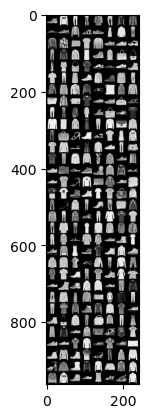

In [4]:
# Do not change this cell
dataiter = iter(test_loader)
images, labels = next(dataiter)
# Show images
imshow(torchvision.utils.make_grid(images))

In [6]:
# TODO: you will design your model here
class ConvModel(nn.Module):
    def __init__(self, input_size, output_size):
        # TODO: complete this method
        super().__init__()

        hidden_size = 32

        # Convolutional layers + activation + pooling
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_size,
                      out_channels=hidden_size,
                      kernel_size=3,
                      stride=1,
                      padding=1),   
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_size,
                      out_channels=hidden_size,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # Reduces 28x28 to 14x14
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_size, hidden_size, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_size, hidden_size, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)     # Reduces 14x14 to 7x7
        )

        # Fully connected classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_size * 7 * 7, out_features=output_size)
        )


    def forward(self, x):
        # TODO: complete this method
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

In [7]:
def train_step(model, train_loader, loss_fn, optimizer, reg_param, device):
    # TODO: implement one epoch of training
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        # Compute prediction loss
        pred_loss = loss_fn(output, target)
        
        # Compute L2 regularization term R(W)
        l2_norm = 0
        for param in model.parameters():
            l2_norm += torch.norm(param, 2)
        
        # Total loss = prediction loss + reg_param * R(W)
        loss = pred_loss + reg_param * l2_norm
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
    avg_loss = train_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy


In [8]:
def evaluation_step(model, data_loader, loss_fn, reg_param, device):
    # TODO: implement evaluation on a data set, data_loader 
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            pred_loss = loss_fn(output, target)
            
            l2_norm = 0
            for param in model.parameters():
                l2_norm += torch.norm(param, 2)
            
            loss = pred_loss + reg_param * l2_norm
            
            test_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
    avg_loss = test_loss / len(data_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy


In [9]:
def train_conv_model(train_loader, valid_loader, test_loader, random_seed):
    # Make device
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    else:
        if torch.backends.mps.is_available():
            device = "mps"

    torch.manual_seed(random_seed)  # do not change this

    # TODO: write codes to train your model here
    # Hyperparameters
    input_size = 1 # 1 channel for FashionMNIST
    output_size = 10
    learning_rate = 0.001
    reg_param = 0.0001
    epochs = 15
    
    model = ConvModel(input_size, output_size).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    test_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model, train_loader, loss_fn, optimizer, reg_param, device)
        valid_loss, valid_acc = evaluation_step(model, valid_loader, loss_fn, reg_param, device)
        test_loss, test_acc = evaluation_step(model, test_loader, loss_fn, reg_param, device)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        
        print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
              
    return model, train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies
    

In [10]:
def plot_accuracy_performance(train_accuracies, valid_accuracies, test_accuracies):
    # TODO: plot accuracy curves, you can reuse your codes from the simple classification task 
    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Performance')
    plt.legend()
    plt.grid(True)
    plt.show()


In [11]:
def plot_loss_performance(train_losses, valid_losses, test_losses):
    # TODO: plot loss curves, you can reuse your codes from the simple classification task
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Performance')
    plt.legend()
    plt.grid(True)
    plt.show()


In [12]:
# Do not change this cell
random_seed = 1
model, train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies\
= train_conv_model(train_loader, valid_loader, test_loader, random_seed)

Epoch 1/15: Train Loss: 0.7168, Train Acc: 73.78%, Valid Loss: 0.4441, Valid Acc: 84.13%, Test Loss: 0.4580, Test Acc: 83.49%
Epoch 2/15: Train Loss: 0.3925, Train Acc: 85.95%, Valid Loss: 0.3559, Valid Acc: 86.97%, Test Loss: 0.3829, Test Acc: 86.03%
Epoch 3/15: Train Loss: 0.3465, Train Acc: 87.51%, Valid Loss: 0.3393, Valid Acc: 87.56%, Test Loss: 0.3531, Test Acc: 87.53%
Epoch 4/15: Train Loss: 0.3099, Train Acc: 89.06%, Valid Loss: 0.2895, Valid Acc: 89.53%, Test Loss: 0.3086, Test Acc: 88.78%
Epoch 5/15: Train Loss: 0.2855, Train Acc: 89.86%, Valid Loss: 0.2818, Valid Acc: 89.78%, Test Loss: 0.3021, Test Acc: 88.95%
Epoch 6/15: Train Loss: 0.2708, Train Acc: 90.35%, Valid Loss: 0.2769, Valid Acc: 90.00%, Test Loss: 0.2976, Test Acc: 89.24%
Epoch 7/15: Train Loss: 0.2580, Train Acc: 90.81%, Valid Loss: 0.2799, Valid Acc: 89.83%, Test Loss: 0.3038, Test Acc: 89.15%
Epoch 8/15: Train Loss: 0.2475, Train Acc: 91.22%, Valid Loss: 0.2688, Valid Acc: 90.38%, Test Loss: 0.2913, Test Acc:

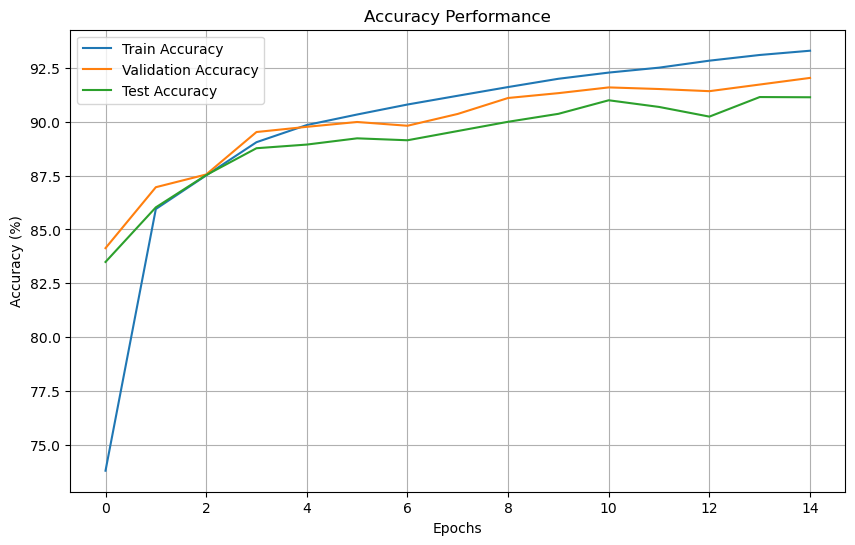

In [13]:
# Do not change this cell
plot_accuracy_performance(train_accuracies, valid_accuracies, test_accuracies)

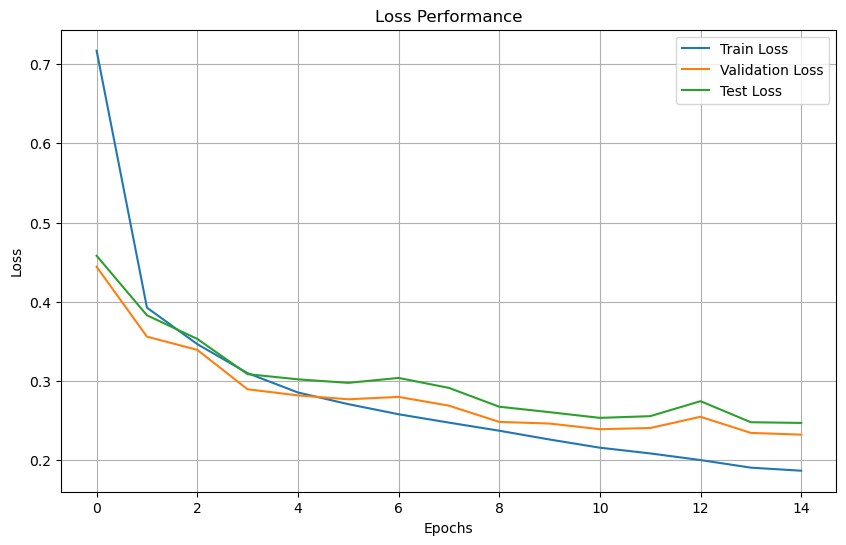

In [14]:
# Do not change this cell
plot_loss_performance(train_losses, valid_losses, test_losses)